# Decoding Debt: Loan Repayment Prediction with LendingClub
By Daniel Weiland

# Introduction
In this project, we dive into publicly available lending data from LendingClub.com spanning the years 2007 to 2010. Lending Club serves as a platform connecting borrowers in need of funds with investors seeking investment opportunities. **The objective of this analysis is to develop a model capable of accurately predicting the not.fully.paid variable, and to assess the effectiveness of LendingClub's underwriting criteria at identifying these not.fully.paid consumers.**

In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from IPython.display import display, Math

%matplotlib inline

In [2]:
#import data
df = pd.read_csv('loan_data.csv')

## The Data

1. **credit.policy:** 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
2. **purpose**: The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", and "all_other").
3. **int.rate**: The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates.
4. **installment**: The monthly installments owed by the borrower if the loan is funded.
5. **log.annual.inc**: The natural log of the self-reported annual income of the borrower.
6. **dti**: The debt-to-income ratio of the borrower (amount of debt divided by annual income).
7. **fico**: The FICO credit score of the borrower.
8. **days.with.cr.line**: The number of days the borrower has had a credit line.
9. **revol.bal**: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).
10. **revol.util**: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).
11. **inq.last.6mths**: The borrower's number of inquiries by creditors in the last 6 months.
12. **delinq.2yrs**: The number of times the borrower had been 30+ days past due on a payment in the past 2 years.
13. **pub.rec**: The borrower's number of derogatory public records (bankruptcy filings, tax liens, or judgments).
14. **not.fully.paid**: 1 if the consumer failed to pay the loan in full, and 0 otherwise.

## Exploratory Data Analysis
First, let's get a better idea of the data that we have to work with, and see if we can identify any interesting trends or underlying distributions that may provide us with insights for our analysis.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [4]:
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


Within our columns we have a few different types of variables: continuous numeric variables, discrete numeric variables, binary variables, and one categorical variable.  We run the code below for the purpose of handling these different values further along in our analysis.

In [5]:
numeric_cols = ["int.rate", "installment", "log.annual.inc", "dti", "fico", "days.with.cr.line", "revol.bal", "revol.util"]
count_numeric_cols = [ "inq.last.6mths", "delinq.2yrs", "pub.rec"]

In [6]:
display(df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
credit.policy,9578.0,0.804970,0.396245,0.000000,1.000000,1.000000,1.000000,1.000000e+00
int.rate,9578.0,0.122640,0.026847,0.060000,0.103900,0.122100,0.140700,2.164000e-01
installment,9578.0,319.089413,207.071301,15.670000,163.770000,268.950000,432.762500,9.401400e+02
log.annual.inc,9578.0,10.932117,0.614813,7.547502,10.558414,10.928884,11.291293,1.452835e+01
dti,9578.0,12.606679,6.883970,0.000000,7.212500,12.665000,17.950000,2.996000e+01
fico,9578.0,710.846314,37.970537,612.000000,682.000000,707.000000,737.000000,8.270000e+02
days.with.cr.line,9578.0,4560.767197,2496.930377,178.958333,2820.000000,4139.958333,5730.000000,1.763996e+04
revol.bal,9578.0,16913.963876,33756.189557,0.000000,3187.000000,8596.000000,18249.500000,1.207359e+06
revol.util,9578.0,46.799236,29.014417,0.000000,22.600000,46.300000,70.900000,1.190000e+02
inq.last.6mths,9578.0,1.577469,2.200245,0.000000,0.000000,1.000000,2.000000,3.300000e+01


When looking into our dependent variable: not.fully.paid, we see that **~16% of the loans within the data set were not fully paid.**

In [7]:
#check null values (commented out because it turns out there are none)
#df.isnull().sum()

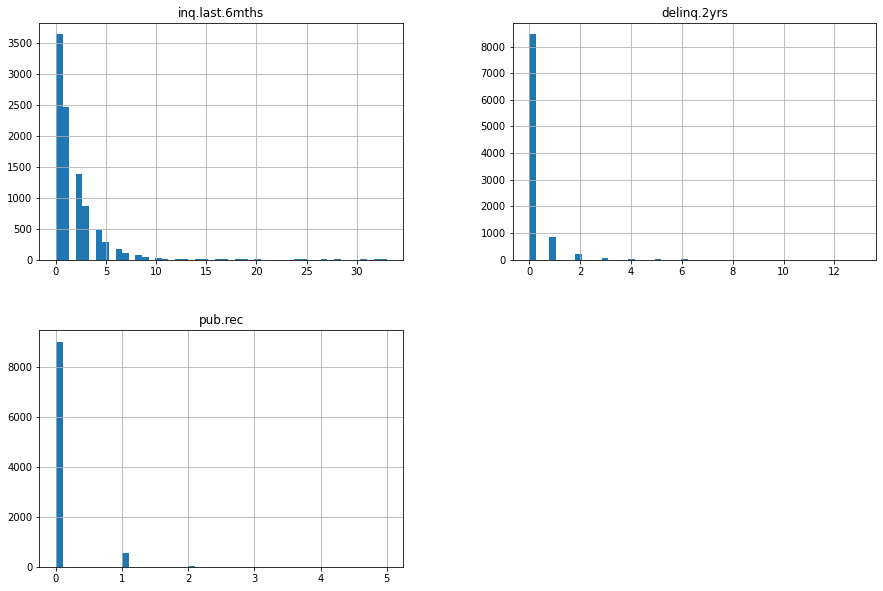

In [8]:
#Histogram distribution of all numeric columns, visualize how these variables are distributed
df[count_numeric_cols].hist(bins=50, figsize=(15,10))
plt.show()

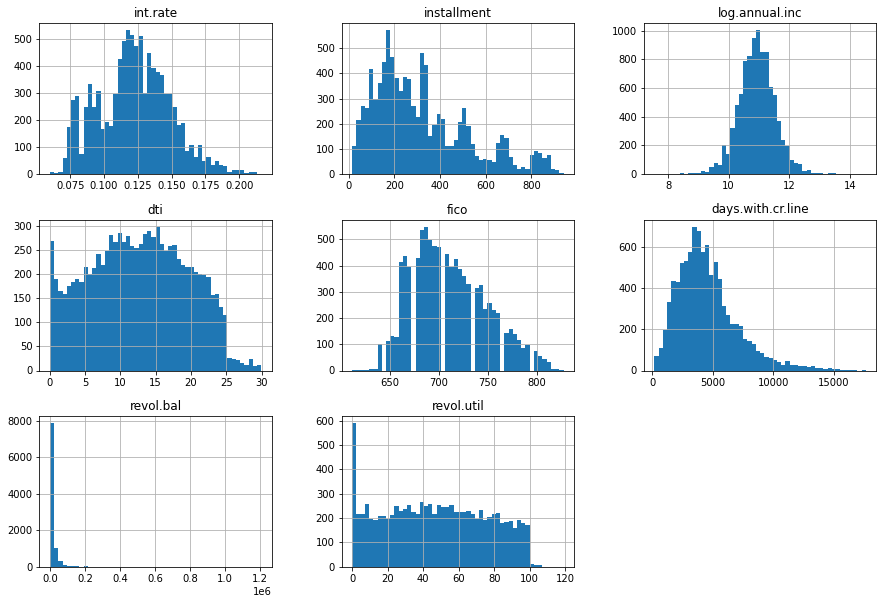

In [9]:
df[numeric_cols].hist(bins=50, figsize=(15,10))
plt.show()

Text(0.5, 1.0, 'Correlation Matrix for All Variables')

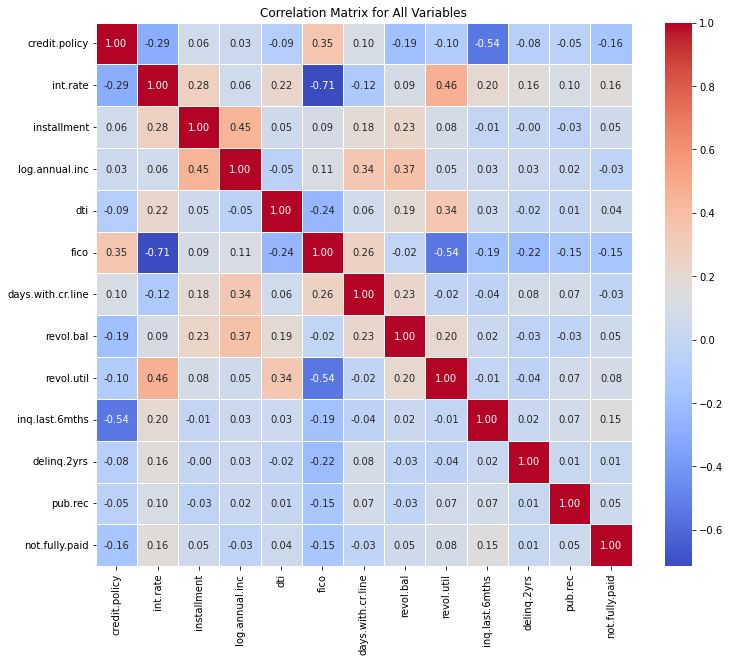

In [10]:
#Plotting correlation matrix of all numerical variables
correlation_matrix = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix for All Variables')

Let's look into our one categorical variable by calculating the conditional probability of loan repayment given that a loan falls under a specific category:

In [11]:
#probability of repayment, given loan reason B

#first let's calculate the number of loangs by purpose
loans_by_purpose = df['purpose'].value_counts()

#then lets find hte number of those loans that haven't defaulted
paid_loans_by_purpose = df[df['not.fully.paid'] == 0]['purpose'].value_counts()

#finally, let's calculate the probability of repaymeny for each loan purpose
prob_repayment_by_purpose = paid_loans_by_purpose / loans_by_purpose

display(prob_repayment_by_purpose.reset_index().rename(columns={'index':'purpose', 'purpose':'P(not.fully.paid)'}))


,purpose,P(not.fully.paid)
0,debt_consolidation,0.847612
1,all_other,0.833977
2,credit_card,0.884311
3,home_improvement,0.829889
4,small_business,0.722132
5,major_purchase,0.887872
6,educational,0.798834


We can see that **there is substantial variance between these loan purposes**, and that **small_business loans have the highest probability of being not fully paid**.

# Logistic Regression Model

## Data Pre-Processing
First, I need to convert this data into a form that is fit to go into my model.  This process includes converting categorical variables into "dummy" variables, and scaling the continuous values.  The data frame for this model will be called df1.

In [12]:
df1 = df.copy(deep=True)

#drop the credit.policy column
df1 = df1.drop('credit.policy', axis=1)

#scale the continuous numeric columns
scaler = StandardScaler()
df1[numeric_cols] = scaler.fit_transform(df1[numeric_cols])

#Create dummy variables for purpose
df1 = pd.get_dummies(df1, columns=['purpose'])

## Implementing the Logistic Regression Model
Once pre-processing is complete, we split the data into train and test sets, run the model on the data, then asess how well our model performed.

In [13]:
#Split data into training and testing sets
X = df1.drop('not.fully.paid', axis=1)
y = df1['not.fully.paid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=25)

#Fit the model on our training data
model = LogisticRegression()
model.fit(X_train, y_train)

#Run the model on our testing data
y_pred = model.predict(X_test)

## Model Feature Examination

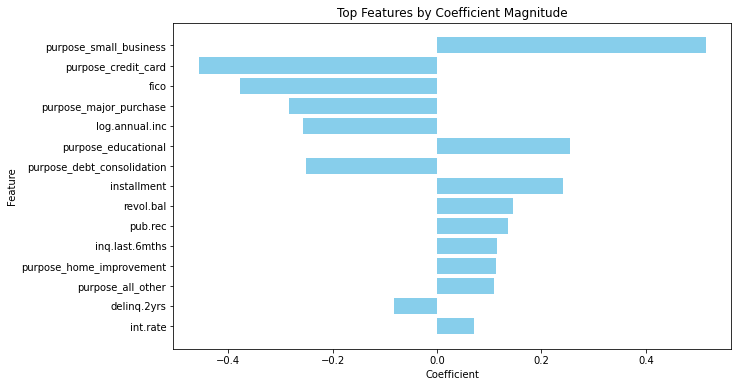

In [14]:
coefficients = model.coef_[0]
feature_names = X.columns

# Create a DataFrame to store coefficients and corresponding feature names
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by coefficient magnitude to identify important features
coefficients_df = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index)

# Optionally, visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(coefficients_df['Feature'][:15], coefficients_df['Coefficient'][:15], color='skyblue')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Top Features by Coefficient Magnitude')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient at the top
plt.show()

The graph above displays the sizes of the coefficients in our model, with a larger coefficient representing a value that provides a larger proportion of explained variance within our model.

In alignment with our previous findings from our EDA: it appears that the loan_purpose variable has a substantial effect on the probability of loan repayment.  We also notice that the "fico" variable is one of our largest negative coefficients,  indicating that a consumer with a higher FICO score would be less likely to not pay back their loan.

## Assessing Logistic Regression Model Accuracy

In [15]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8423799582463466


**Our model correctly predicted the not.fully.paid value ~84.24% of the time**.  At first glance, that's not too bad! Let's look further into our models predictions. 

### Confusion Matrix

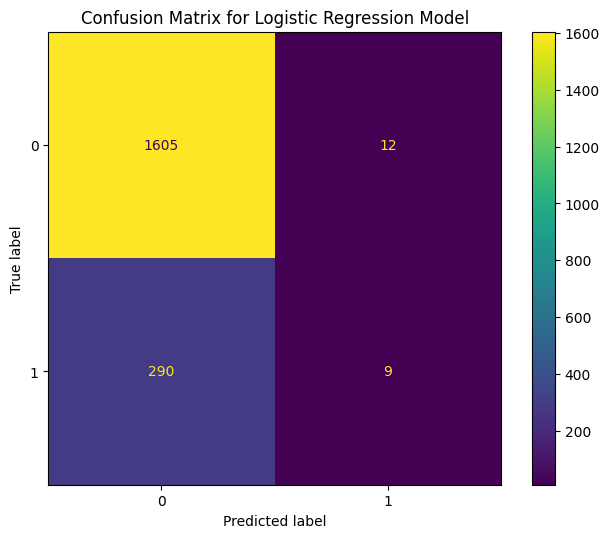

In [16]:
#Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

#Now make it pretty
fig, ax = plt.subplots(figsize=(8,6), dpi=100)

confusion_display = ConfusionMatrixDisplay(conf_matrix, display_labels=model.classes_)
ax.set(title='Confusion Matrix for Logistic Regression Model')

confusion_display.plot(ax=ax)

As a reminder, a value of 0 means that a consumer did not default on their loan, whereas a value of 1 means that the consumer did default on their loan.  From the 1,916 observations within our test set, we can see that our model:
- **correctly** predicted a 0 value 1,605 times
- **correctly** predicted a 1 value 9 times
- **incorrectly** predicted a 0 value 290 times
- **incorrectly** predicted a 1 value 12 times

Upon further assessment, an issue in our model becomes more apparent. **While our model appears to perform well at predicting when a consumer will *did not* default on their loan, it performed poorly at predicting if a consumer *did* default on their loan.**

In [17]:
print("TOTAL PREDICTIONS:",len(y_pred))
print("% OF PREDICTIONS WHERE not.fully.paid = 1:", str(y_pred.mean())[3] + "." + str(y_pred.mean())[4:6] + "%")

TOTAL PREDICTIONS: 1916
% OF PREDICTIONS WHERE not.fully.paid = 1: 1.09%


# LendingClub Underwriting Criteria
**Assumption**: LendingClub's credit.policy == 0 means consumer is likely to not pay back their loan

In [18]:
#Generate the confusion matrix.  We switch 1 and 0 in the credit policy so that a 1 represents a consumer that 
#LendingClub predics would NOT pay back the loan
df2 = df.copy(deep = True)
df2["credit.policy"] = df["credit.policy"].replace({0:1, 1:0})

conf_matrix_lend = confusion_matrix(df2["not.fully.paid"], df2["credit.policy"])

confusion_display_lend = ConfusionMatrixDisplay(conf_matrix_lend, display_labels=model.classes_)
ax.set(title='Confusion Matrix for LendingClub Underwriting Criteria')

conf_disp_lend = confusion_display_lend.plot(ax=ax)

### Prediction Accuracy

In [19]:
accuracy2 = accuracy_score(df2["credit.policy"], df2["not.fully.paid"])
print("Accuracy:", accuracy2)

Accuracy: 0.7532887868030904


We see that **LendingClub's decision whether to provide a consumer with a lon is correct ~75.33% of the time.**

# Comparing Predictive Performance between Logistic Regression and LendingClub Underwriting Criteria

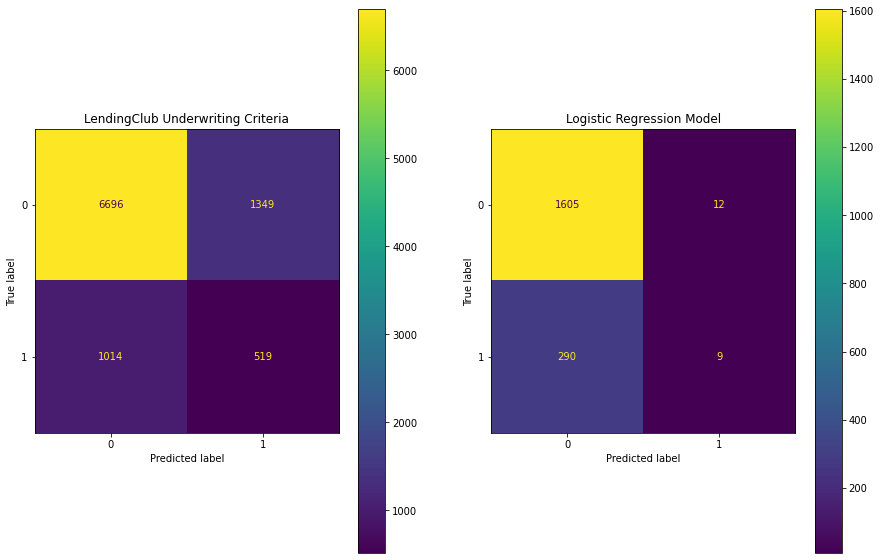

In [20]:
#Plot the two confusion matrices side by side and compare
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 10))

confusion_display_lend.plot(ax=ax1)

confusion_display.plot(ax=ax2)

ax1.set_title('LendingClub Underwriting Criteria')
ax2.set_title('Logistic Regression Model')

plt.show()

In [21]:
print("LENDINGCLUB CONFUSION MATRIX")
print(conf_matrix_lend/conf_matrix_lend.sum())
print("")
print("LOGISTIC REGRESSION CONFUSION MATRIX")
print(conf_matrix /conf_matrix.sum())
print("")

LENDINGCLUB CONFUSION MATRIX
[[0.69910211 0.1408436 ]
 [0.10586761 0.05418668]]

LOGISTIC REGRESSION CONFUSION MATRIX
[[0.83768267 0.00626305]
 [0.15135699 0.00469729]]



From the confusion matrices plotted in the graphs, and the percentage adjusted confusion matrices printed below them, we are able to recognize some differences in how the models perform. **The LendingClub underwriting criteria predicted that loans would be not.fully.paid at a substantially higher rate than our logistic regression model, and its ~75.33% prediction accuracy was lower than the ~84.24% accuracy of our Logistic Regression model.**  

# Conclusion

While the Logistic Regression model was more likely to experience Type II Errors (A "False Negative" where they predicted not.fully.paid = 0, when the true label was 1),  the LendingClub underwriting criteria was *substantially* more prone to Type I errors (A "False Positive" where they predicted not.fully.paid = 1, when the true label was 0).  

Although our Logistic Regression model was able to make correct predictions at a higher rate, in order to declare whether the Logistic Regression model is "better", we would need to better understand the strategy of LendingClub.  Based off of the highger rate of Type I errors, I would predict that the negative impact of not offering a loan to a consumer that would be fully paid back (Type I Error) is less costly than offering a loan to a consumer that would not be fully paid back.

Further improvement of our predictive model would require additional alignment with stakeholders to understand the impacts of these Type I and Type II errors.  We could also potentially improve our predictive power by testing additional classification models (Decision Trees, KNN, etc.) and comparing performance.  